# Matrizes

Matrizes são maneiras eficientes de representação de várias coisas, em especial transformações lineares.
Muitas aplicações práticas caem em sistemas lineares, e mais outras têm representações matriciais.
Sendo assim, a execução eficiente da chamada **álgebra linear numérica** é essencial.

## BLAS

**BLAS - Basic Linear Algebra Subroutines**, corresponde à uma classe de softwares que implementam álgebra linear numérica. Existem diversos BLAS, sendo alguns proprietários, alguns abertos, alguns genéricos, e alguns específicos para o processador. O BLAS é uma das unidades mais básicas do software matemático, e não vamos tentar reimplementá-lo. Porém, vamos estudar alguns aspectos que são a base para coisas mais avançadas.

In [1]:
A = rand(3,3)
v = rand(3)
A * v

3-element Array{Float64,1}:
 1.1379622868967738
 0.7193047626970368
 1.5768115458510683

In [2]:
using LinearAlgebra

In [3]:
?LinearAlgebra.BLAS.dot

```
dot(n, X, incx, Y, incy)
```

Dot product of two vectors consisting of `n` elements of array `X` with stride `incx` and `n` elements of array `Y` with stride `incy`.

# Examples

```jldoctest
julia> dot(10, fill(1.0, 10), 1, fill(1.0, 20), 2)
10.0
```


In [4]:
names(LinearAlgebra.BLAS)

47-element Array{Symbol,1}:
 :BLAS     
 :asum     
 :axpby!   
 :axpy!    
 :blascopy!
 :dot      
 :dotc     
 :dotu     
 :gbmv     
 :gbmv!    
 :gemm     
 :gemm!    
 :gemv     
 ⋮         
 :syr2k    
 :syr2k!   
 :syrk     
 :syrk!    
 :trmm     
 :trmm!    
 :trmv     
 :trmv!    
 :trsm     
 :trsm!    
 :trsv     
 :trsv!    

In [5]:
?LinearAlgebra.BLAS.trmv

```
trmv(ul, tA, dA, A, b)
```

Return `op(A)*b`, where `op` is determined by [`tA`](@ref stdlib-blas-trans). Only the [`ul`](@ref stdlib-blas-uplo) triangle of `A` is used. [`dA`](@ref stdlib-blas-diag) determines if the diagonal values are read or are assumed to be all ones.


As operações são classificas em ordens diferentes, de acordo com o número de operações. Alguns exemplos:
- Nível 1: $\alpha x + y$, $x^Ty$;
- Nível 2: $Ax$, $L^{-1}b$ e $U^{-1}b$, onde $L$ e $U$ são matrizes triangulares inferior e superior, resp.;
- Nível 3: $AB$ e algumas maneiras de resolver sistemas lineares.

### $\alpha x + y$

Sendo $z = \alpha x + y$, temos $z_i = \alpha x_i + y_i$, então fazemos $n$ multiplicações e $n$ somas: $2n$ operações.

### $x^Ty$

$x^Ty = x_1y_1 + \dots + x_ny_n$, logo são $n$ multiplicações e $n-1$ somas: $2n - 1$ operações.

### Ax

Sendo $y = Ax$, com $A \in \mathbb{R}^{m \times n}$, temos
$$ y_i = \sum_{j = 1}^n a_{ij} x_j, \quad i = 1,\dots,m. $$
Logo, são $mn$ multiplicações e $(n-1)m$ somas: $2mn - m$ operações.

### AB

Sendo $C = AB$, com $A \in \mathbb{R}^{m \times p}$ e $B \in \mathbb{R}^{p \times n}$, temos
$$ c_{ij} = \sum_{k = 1}^p a_{ik} b_{kj}, \qquad i = 1,\dots,m,\quad j = 1,\dots,n. $$
Logo, são $mnp$ multiplicações e $(p-1)mn$ somas: $2mnp - mn$ operações.

## Armazenamento

Existe um conceito de matriz **densa** e **esparsa**. Quando uma matriz tem muitos zeros, ela é dita esparsa (é um conceito *fuzzy*). Para matrizes realmente grandes, armazenar todos os elementos, inclusive os nulos, é inviável, ou até impossível.

O armazenamento de matrizes densas em geral é feito como um vetor linearizado. Isto é, espaços contíguos na memória. Isso é feito para minimizar o *seek*, i.e., a busca na memória. Isso quer dizer também que **faz diferença como a matriz é percorrida.**

In [6]:
using BenchmarkTools, LinearAlgebra

function multAx1(y, A, x)
    m, n = size(A)
    for i = 1:m
        y[i] = 0.0
        for j = 1:n
            y[i] += A[i,j] * x[j]
        end
    end
end

function multAx2(y, A, x)
    m, n = size(A)
    for i = 1:m
        y[i] = 0.0
    end
    for j = 1:n
        for i = 1:m
            y[i] += A[i,j] * x[j]
        end
    end
end

multAx2 (generic function with 1 method)

In [7]:
n = 1000
A = rand(n, n)
x = rand(n)
y = zeros(n);

In [8]:
y1 = zeros(n)
y2 = zeros(n)
multAx1(y1, A, x)
multAx2(y2, A, x)
norm(y1 - y2)

0.0

In [9]:
@benchmark multAx1(y, $A, $x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     1.898 ms (0.00% GC)
  median time:      2.148 ms (0.00% GC)
  mean time:        2.275 ms (0.00% GC)
  maximum time:     4.597 ms (0.00% GC)
  --------------
  samples:          2191
  evals/sample:     1

In [10]:
@benchmark multAx2(y, $A, $x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     769.754 μs (0.00% GC)
  median time:      825.186 μs (0.00% GC)
  mean time:        923.971 μs (0.00% GC)
  maximum time:     2.897 ms (0.00% GC)
  --------------
  samples:          5378
  evals/sample:     1

In [11]:
A = rand(3, 3)

3×3 Array{Float64,2}:
 0.285783  0.554391  0.517935
 0.689746  0.381781  0.372618
 0.727182  0.905362  0.21241 

In [12]:
A[:]

9-element Array{Float64,1}:
 0.28578324692079193
 0.6897455206196306 
 0.7271818614003505 
 0.554391140750367  
 0.3817806574809539 
 0.9053618026261785 
 0.5179348886317929 
 0.3726181633367709 
 0.21240955978444243

Para matrizes esparsas, o armazenamento pode ser muito mais complicado. A estratégia mais simples é armazenar todos os índices e valores. No Julia, existem ferramentas para trabalhar com matrizes esparsas nativamente.

In [13]:
using SparseArrays

A = sprand(4, 4, 0.3)

4×4 SparseMatrixCSC{Float64,Int64} with 3 stored entries:
  [1, 3]  =  0.162423
  [1, 4]  =  0.37004
  [3, 4]  =  0.378365

In [14]:
Matrix(A)

4×4 Array{Float64,2}:
 0.0  0.0  0.162423  0.37004 
 0.0  0.0  0.0       0.0     
 0.0  0.0  0.0       0.378365
 0.0  0.0  0.0       0.0     

In [15]:
rows, cols, vals = findnz(A)

([1, 1, 3], [3, 4, 4], [0.162423, 0.37004, 0.378365])

In [16]:
[rows cols vals]

3×3 Array{Float64,2}:
 1.0  3.0  0.162423
 1.0  4.0  0.37004 
 3.0  4.0  0.378365

In [17]:
function multAxs(y, rows, cols, vals, x)
    n = length(y)
    for i = 1:n
        y[i] = 0.0
    end
    nz = length(vals)
    for k = 1:nz
        i, j = rows[k], cols[k]
        y[i] += vals[k] * x[j]
    end
end

multAxs (generic function with 1 method)

In [18]:
x = rand(4)
y = A * x
ys = zeros(4)
multAxs(ys, rows, cols, vals, x)

In [19]:
y - ys

4-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0

In [20]:
A

4×4 SparseMatrixCSC{Float64,Int64} with 3 stored entries:
  [1, 3]  =  0.162423
  [1, 4]  =  0.37004
  [3, 4]  =  0.378365

# Sistemas Lineares

Sistemas lineares são extremamentes importantes. Em quase todas aplicações avançadas teremos sistemas lineares.
Em muitos casos, esses sistemas serão especiais, de modo que teremos métodos especiais para resolvê-los.
Estudaremos aqui, no entanto, a maneira mais geral de resolvê-los. Estudos mais avançados serão feitos em disciplinas posteriores.

## A barra invertida

Em Julia e Matlab/Octave, existe um comando especial e simples para se resolver sistemas lineares: a barra invertida `\`.

In [21]:
A = rand(3, 3)
b = A * ones(3)
# b foi criado para que Ax = b tenha como solução o vetor de uns.
x = A\b

3-element Array{Float64,1}:
 0.9999999999999973
 1.0000000000000007
 1.0000000000000004

In [22]:
A = zeros(5,5) + 2I
for i = 1:4
    A[i,i+1] = 1
    A[i+1,i] = 1
end
A

5×5 Array{Float64,2}:
 2.0  1.0  0.0  0.0  0.0
 1.0  2.0  1.0  0.0  0.0
 0.0  1.0  2.0  1.0  0.0
 0.0  0.0  1.0  2.0  1.0
 0.0  0.0  0.0  1.0  2.0

In [23]:
b = A * ones(5)
A \ b

5-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0

A barra invertida facilita grandemente a resolução de sistemas. No entanto, é importante, principalmente para matemáticos industriais, aplicados e computacionais, entender o que acontece na resolução de um sistema. Além disso, também existem vários casos em que o uso da barra invertida será pior que o conhecimento específico sobre o problema.

## Eliminação Gaussiana

O método mais simples de resolução de sistemas lineares é o equivalente ao chamado escalonamento.

Relembrando. Dado uma matriz $A$ e um vetor $b$, o escalonamento da matriz aumentada
$\left[\begin{array}{cc} A & b \end{array}\right]$ é o processo de transformar essa matriz em uma matriz com vários zeros montando um tipo de escada. Com mais detalhes, é uma matriz tal que 
- Todas as linhas começam com um ou mais zeros que a linha de cima, a não que seja toda nula;
- Todas as linhas nulas estão abaixo de qualquer linha não toda nula.

Uma matriz é transformada numa matriz escalonada através de operações elementares nas linhas da matriz. Essa operações são
- multiplicar uma linha por um número não-nulo;
- trocar duas linhas de posição;
- somar à uma linha um múltiplo de outra.

Se $A$ é uma matriz quadrada e inversível, então é garantido que a matriz aumentada escalonada será da forma
$\left[\begin{array}{cc}U & c
\end{array}\right]$,
onde $C$ é uma matriz triangular superior com diagonal não nula, isto é
$c_{i,j} = 0$ se $i > j$, e $c_{i,i} \neq 0$. Em outras palavras, a primeira linha é não nula, e cada linha abaixo tem um zero a mais que a anterior.

In [24]:
# Exemplo
U = triu(rand(1:999, 10, 10)) / 1000

10×10 Array{Float64,2}:
 0.197  0.979  0.981  0.146  0.593  0.212  0.779  0.837  0.593  0.545
 0.0    0.482  0.176  0.374  0.456  0.209  0.262  0.778  0.926  0.244
 0.0    0.0    0.48   0.718  0.35   0.372  0.158  0.696  0.469  0.931
 0.0    0.0    0.0    0.807  0.241  0.888  0.472  0.361  0.516  0.601
 0.0    0.0    0.0    0.0    0.415  0.948  0.365  0.356  0.672  0.832
 0.0    0.0    0.0    0.0    0.0    0.234  0.179  0.315  0.813  0.07 
 0.0    0.0    0.0    0.0    0.0    0.0    0.212  0.115  0.875  0.653
 0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.499  0.153  0.171
 0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.47   0.39 
 0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.582

Computacionalmente, vamos fazer as mesmas operações, com exceção da multiplicação de uma linha por um número, por motivos que ficarão claros no futuro.
Além disso, o motivo para se mudar as linhas ao fazer essas operações na mão era para facilitar as contas.
Computacionalmente, teremos outros objetivos, e só faremos a mudança de linhas quando necessário.

Portanto, nossa operação principal será a adição de um múltiplo de outra linha a linha atual.
Nossa notação será

$$ L_j \leftarrow L_j + \alpha L_i, $$

para dizer que multiplicamos a linha $i$ por $\alpha$, somamos à linha $j$ e substituímos na linha $j$.

Vamos exemplificar o processo que já conhecemos.

In [25]:
A = [3.0 1 2; -1 2 1; 1 1 4]

3×3 Array{Float64,2}:
  3.0  1.0  2.0
 -1.0  2.0  1.0
  1.0  1.0  4.0

In [26]:
b = [6.0; 2; 6]

3-element Array{Float64,1}:
 6.0
 2.0
 6.0

In [27]:
m21 = A[2,1] / A[1,1]

-0.3333333333333333

In [28]:
# Li = B[i,:]
# L₂ ← L₂ - m₂₁L₁
A[2,:] = A[2,:] - m21 * A[1,:]
b[2] = b[2] - m21 * b[1]

4.0

Note que A[2,1] é zero agora

In [29]:
[A b]

3×4 Array{Float64,2}:
 3.0  1.0      2.0      6.0
 0.0  2.33333  1.66667  4.0
 1.0  1.0      4.0      6.0

In [30]:
# L₃ ← L₃ - m₃₁L₁
m31 = A[3,1]/A[1,1]
A[3,:] = A[3,:] - m31*A[1,:]
b[3] = b[3] - m31*b[1]

4.0

In [31]:
[A b]

3×4 Array{Float64,2}:
 3.0  1.0       2.0      6.0
 0.0  2.33333   1.66667  4.0
 0.0  0.666667  3.33333  4.0

In [32]:
# L₃ ← L₃ - m₃₂L₂
m32 = A[3,2]/A[2,2]
A[3,:] = A[3,:] - m32*A[2,:]
b[3] = b[3] - m32*b[2]

2.8571428571428568

In [33]:
[A b]

3×4 Array{Float64,2}:
 3.0   1.0          2.0      6.0    
 0.0   2.33333      1.66667  4.0    
 0.0  -1.11022e-16  2.85714  2.85714

Agora podemos resolver esse sistema triangular superior facilmente.
Note que, tirando o erro numérico em `A[3,2]`, temos

\begin{align}
a_{11} x_1 + a_{12} x_2 + a_{13} & = b_1 \\
a_{22} x_2 + a_{23} x_3 & = b_2 \\
a_{33} x_3 & = b_3.
\end{align}

Assim, resolvemos esse sistema fazendo

\begin{align}
x_3 & = \frac{b_3}{a_{33}} \\
x_2 & = \frac{b_2 - a_{23}x_3}{a_{22}} \\
x_1 & = \frac{b_1 - a_{13}x_3 - a_{12}x_2}{a_{11}}.
\end{align}

In [44]:
x = zeros(3)
x[3] = b[3] / A[3,3]
x[2] = (b[2] - A[2,3] * x[3]) / A[2,2]
x[1] = (b[1] - A[1,3] * x[3] - A[1,2] * x[2]) / A[1,1]
x

3-element Array{Float64,1}:
 1.0               
 1.0000000000000002
 0.9999999999999999

O processo todo pode ser separado em duas partes:
- A redução à matriz triangular superior, que chamamos de **Eliminação Gaussiana**; e
- A resolução do sistema triangular superior.

O seguinte algoritmo descreve o processo

In [33]:
#=
Entrada: matriz A: n×n e vetor b: n
1. Para j de 1 a n-1
    1. Para i de j+1 a n
        1. Calcule mᵢⱼ = aᵢⱼ/aⱼⱼ
        2. Faça Lᵢ ← Lᵢ - mᵢⱼLⱼ
        3. Faça bᵢ ← bᵢ - mᵢⱼbⱼ
Saída: A triangular superior e 
       b com modificações correspondentes.
=#

Note que para ser bem definido, esse algoritmo precisa que $a_{jj} \neq 0$. Existe um teorema indicando as condições para isso. Antes, definimos $A_{kk}$ como a submatriz de $A$ das linhas 1 a $k$ e colunas 1 a $k$.
Em Julia seria a matriz `A[1:k,1:k]`.

**Teorema:** Se $\det(A_{kk}) \neq 0$ para todo $k = 1,\dots,n-1$, então o método de Eliminação Gaussiana como descrito acima está bem definida, isto é, roda todas as iterações até encontrar uma matriz triangular superior.
Se, além disso, $\det(A) \neq 0$, então a diagonal é não-nula. Caso contrário, o último elemento da diagonal será 0.

Como isso nem sempre será possível, vamos colocar essa condição para falha no algoritmo. Se o elemento da diagonal for muito próximo de zero, retornaremos um erro.

In [56]:
function elim_gauss(A::Matrix, b::Vector; diagtol = 1e-12)
    # Implemente
    n = size(A, 1)
    for j = 1:n-1
        if abs(A[j,j]) < diagtol
            error("Diagonal quase nula")
        end
        for i = j+1:n
            mij = A[i,j] / A[j,j]
            A[i,1:j] .= 0.0
            A[i,j+1:n] -= mij * A[j,j+1:n]
            b[i] -= mij * b[j]
        end
    end
    return A, b
end

elim_gauss (generic function with 1 method)

In [57]:
A = [3.0 1 2; -1 2 1; 1 1 4]
b = [6.0; 2; 6]
elim_gauss(A, b)

([3.0 1.0 2.0; 0.0 2.33333 1.66667; 0.0 0.0 2.85714], [6.0, 4.0, 2.85714])

In [58]:
[A b]

3×4 Array{Float64,2}:
 3.0  1.0      2.0      6.0    
 0.0  2.33333  1.66667  4.0    
 0.0  0.0      2.85714  2.85714

In [59]:
A \ b

3-element Array{Float64,1}:
 1.0               
 1.0000000000000002
 0.9999999999999998

In [53]:
A = [0.0 1.0; 1.0 0.0]

2×2 Array{Float64,2}:
 0.0  1.0
 1.0  0.0

In [54]:
b = ones(2)
elim_gauss(A, b)

ErrorException: Diagonal quase nula

In [55]:
A = [3.0 1 2; -1 2 1; 1 1 4]
b = [6.0; 2; 6]
A \ b

3-element Array{Float64,1}:
 1.0               
 1.0000000000000002
 0.9999999999999999

Agora para o algoritmo de resolução do sistema triangular superior.

In [41]:
#=
Entrada: A: n×n triangular superior com diagonal não-nula
         b: n
1. Crie o vetor x nulo
2. Para i de n à 1
    1. s ← bᵢ
    2. Para j de i+1 à n
        1. s ← s - aᵢⱼxⱼ
    3. xᵢ = s/aᵢᵢ

Saída: x: solução de Ax = b
=#

In [34]:
function sist_tri_sup(A, b)
    n = length(b)
    x = zeros(n)
    # Implementar
    for j = n:-1:1
        if abs(A[j,j]) < 1e-14
            error("Não deu")
        end
        s = b[j]
        for k = j+1:n
            s -= A[j,k] * x[k]
        end
        x[j] = s / A[j,j]
    end
    return x
end

sist_tri_sup (generic function with 1 method)

In [61]:
A = [3.0 1 2; -1 2 1; 1 1 4]
b = [6.0;2;6]
elim_gauss(A, b)
sist_tri_sup(A, b)

3-element Array{Float64,1}:
 1.0               
 1.0000000000000002
 0.9999999999999999

In [63]:
function resolve(A, b)
    Ac = copy(A)
    bc = copy(b)
    elim_gauss(Ac, bc)
    x = sist_tri_sup(Ac, bc)
    return x
end

resolve (generic function with 1 method)

In [64]:
A = rand(100, 100)
b = A * ones(100);

In [72]:
(100 * 100 + 100 + 100) * Float64.size / 1024

79.6875

In [69]:
@time x = resolve(A, b);

  0.006788 seconds (19.81 k allocations: 12.078 MiB)


In [71]:
@time x = A \ b;

  0.000398 seconds (9 allocations: 80.141 KiB)


## Pontos importantes

- $A$ foi perdida. Ela é irrecuperável (sem os valores de $m_{i,j})$. Para prevenir isso, podemos
    - Sol. 1: Não "usar" $A$, i.e., copiar para outra matriz
    - Sol. 2: Guardar $m_{i,j}$.
- A eliminação do elemento $a_{i,j}$ faz contas desnecessárias com 0.0 (antes da coluna $j$).
- $m_{i,j}$ foi calculado com o objetivo de transformar
$a_{i,j}$ em 0.0. Então não é necessário calcular a atualização de $a_{i,j}$. (Basta fazer `A[i,j] = 0.0`).
Sem falar que o resultado pode não ser exatamente 0.0, e
ficar sujando as contas.
- A matriz resultante tem muitos zeros, i.e., gasto de memória a toa.
    - Sol.: Guardar a matriz de um jeito diferente;
    - Sol.: Usar esse espaço vazio.
- `A[i,:]` cria um vetor temporario, então
$L_i \leftarrow L_i - m_{i,j}L_j$ tem um gasto de memória desnecessário.
    - Nesta disciplina, vamos ignorar esse fato, sempre que não afetar demais;
    - A maneira tradicional de resolver esse problema é usar `for`;
    - O Julia permite alguns comandos que fazem isso automático pra você.

Uma melhoria no método, que zera os elementos que deveriam ser zerados e restringe as contas feitas, está abaixo.

In [35]:
function elim_gauss(A::Matrix, b::Vector; diagtol = 1e-12)
    n = length(b)
    for j = 1:n-1
        ajj, bj = A[j,j], b[j]
        if abs(ajj) <= diagtol
            error("Diagonal muito próxima de 0")
        end
        for i = j+1:n
            mij = A[i,j] / ajj
            A[i,j] = 0.0
            A[i,j+1:n] -= mij * A[j,j+1:n]
            b[i] -= mij * bj
        end
    end
    return A, b
end

elim_gauss (generic function with 1 method)

In [50]:
A = [3.0 1 2; -1 2 1; 1 1 4]
b = [6.0;2;6]
elim_gauss(A, b)
A

3×3 Array{Float64,2}:
 3.0  1.0      2.0    
 0.0  2.33333  1.66667
 0.0  0.0      2.85714

In [51]:
A \ b

3-element Array{Float64,1}:
 1.0               
 1.0000000000000002
 0.9999999999999998

In [84]:
#A = [1e-11 100; 1 1e-11]
A = [1 1e-11; 1e-11 100]

2×2 Array{Float64,2}:
 1.0        1.0e-11
 1.0e-11  100.0    

In [85]:
b = A * ones(2)

2-element Array{Float64,1}:
   1.00000000001
 100.00000000001

In [86]:
resolve(A, b) .- 1

2-element Array{Float64,1}:
 0.0
 0.0

In [83]:
cond(A)

100.0

## Pivoteamento

Pivoteamento é o nome dado à troca de linhas no processo de eliminação Gaussiana.
Às vezes podemos fazer troca de colunas também, e para diferenciar costuma-se dizer
eliminação Gaussiana com pivoteamento parcial.

O primeiro motivo pelo qual o pivoteamento é importante é o zero na diagonal.

In [52]:
A = [0 1; 1 0]

2×2 Array{Int64,2}:
 0  1
 1  0

Essa matriz, apesar de trivial, não passa no teste da nossa função de eliminação Gaussiana.
Além disso, existem outros problemas.

In [3]:
ϵ = 1e-12
A = [ϵ 100; 1.0 ϵ]
B = copy(A)
b = A * ones(2)
elim_gauss(A, b, diagtol=0.0)

([1.0e-12 100.0; 0.0 -1.0e14], [100.0, -1.0e14])

In [8]:
x = sist_tri_sup(A, b)
x - ones(2)

2-element Array{Float64,1}:
 -0.00524016993585974
  0.0                

In [14]:
2.0^(-40)

9.094947017729282e-13

In [25]:
ϵ = 1e-15
((100 + ϵ) - 100) / ϵ

0.0

In [10]:
A = B[[2;1], :]

2×2 Array{Float64,2}:
 1.0        1.0e-12
 1.0e-12  100.0    

In [12]:
b = A * ones(2)
elim_gauss(A, b)
x = sist_tri_sup(A, b)
x - ones(2)

2-element Array{Float64,1}:
 0.0
 0.0

In [27]:
using LinearAlgebra
cond(A)

100.0

A matriz $A$ no exemplo acima
$$ A = \left[\begin{array}{cc}
\epsilon & 100 \\
1 & \epsilon
\end{array}\right],$$
introduz um problema durante a eliminação Gaussiana.
O elemento $a_{22}$ deve ser substituído por
$$ \epsilon - \frac{100}{\epsilon}. $$
Quando $\epsilon$ é pequeno, ocorre um underflow considerável nessa operação, de modo que fica aproximada
por $-\dfrac{100}{\epsilon}$.

O vetor $b$, que inicialmente é
$\left[\begin{array}{c} 100 + \epsilon \\ 1 + \epsilon\end{array}\right],$
vira
$\left[\begin{array}{c} 100 + \epsilon \\ 1 + \epsilon - \dfrac{100 + \epsilon}{\epsilon} \end{array}\right],$

Nem $100 + \epsilon$, nem $1 + \epsilon$ têm erros grandes. Por outro lado,
$$ 1 + \epsilon - \frac{100 + \epsilon}{\epsilon} = \epsilon - \frac{100}{\epsilon} \approx -\frac{100}{\epsilon}.$$

Ou seja, acaba acontecendo um erro similar em $b_2$, de modo que o $x_2$ encontrado é $1.0$.

Daí,
$$ x_1 = \frac{ (100 + \epsilon) - 100 }{\epsilon}. $$
A subtração tem um erro pequeno, mas quando dividido por $\epsilon$, fica considerável.

A matriz com as linhas trocadas, no entanto, não teve esse problema.

$$ A = \left[\begin{array}{cc}
1 & \epsilon \\
\epsilon & 100
\end{array}\right]
\qquad
\mbox{e}
\qquad
b = \left[\begin{array}{c}
1 + \epsilon \\
100 + \epsilon
\end{array}\right]
.$$

Temos $$ m_{21} = \epsilon, $$
daí
$$ a_{22} \leftarrow 100 - \epsilon^2 \approx 100, $$
e
$$ b_2 \leftarrow (100 + \epsilon) - \epsilon (1 + \epsilon) \approx 100. $$

Novamente $x_2 = 1$. Agora
$$ x_1 = \frac{ (1 + \epsilon) - \epsilon }{1} = 1. $$
Novamente o erro na subtração é grande, porém a divisão não aumenta esse erro.

Em outras palavras, podemos tentar pivotear a matriz $A$ para **aumentar a estabilidade numérica**.
Outro motivo para o pivoteamento está abaixo.

### Esparsidade

Uma matriz é dita **esparsa** se contém muitos zeros. Esse termo não é exato, o que complica um pouco, e não faz muito sentido para matrizes pequenas, mas vamos tentar elucidá-lo e explicar a sua importância.

A densidade de $A$ é o número de elementos não nulos divido pelo número de elementos total de $A$.

Em geral, o limite para se considerar uma matriz esparsa não é estabelecido, principalmente por depender da dimensão $n$ de $A$. Em geral, uma matriz com 1% de elementos não nulos é considerada esparsa. Uma com 10% às vezes será considerada esparsa. Uma matriz diagonal, por exemplo, é a matriz mais esparsa possível que pode ser não-singular (permutações da matriz diagonal também). O número de elementos não-nulos da matriz diagonal é $n$, e seu número de elementos é $n^2$. Portanto, sua densidade é $1/n$. Se $n > 1000$, então a densidade será menor que $0.001$.

Uma matriz tridiagonal - onde só podem ser não-nulos os elementos na diagonal, na diagonal acima, e na diagonal abaixo, terá densidade $\dfrac{3n-2}{n^2}$. No caso $n = 1000$, será $\approx 0.003$, e ainda é considerada esparsa.

Uma matriz de banda $k$ - onde as diagonais até $k$ acima e até $k$ abaixo da diagonal principal contém todos os elementos não-nulos - tem $n + 2(n-1) + 2(n-2) + \dots 2(n-k) = n + 2\sum_{i = 1}^k(n-i) = n(1 + 2k) - k(k+1)$
elementos. Uma matriz com $n = 1000$ e $k = 50$, terá esparsidade $\approx 0.1$, que ainda está bom. Veja que já é 10%.

Quando fazemos operações com matrizes esparsas, os cálculos envolvendo os elementos nulos tem custo nulo, além de não produzirem erros. Além disso, uma matriz esparsa irá ocupar muito menos espaço no computador.
Por isso matrizes esparsas são desejáveis.
Por outro lado, algumas operações na matriz fazem com que sua densidade aumente, por isso devemos tomar muito cuidade em como fazê-las.

Em particular, uma matriz esparsa pode se tornar bastante densa na operação de eliminação Gaussiana.

In [37]:
using Plots

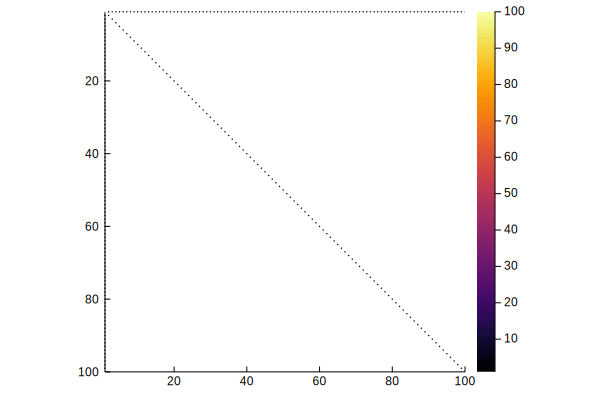

In [38]:
using SparseArrays

n = 100
A = diagm(0 => ones(n))
A[:,1] .= 1.0
A[1,:] .= 1.0
A[1,1] = n
A
spy(sparse(A))

In [39]:
b = A * ones(n)
elim_gauss(A, b)
A

100×100 Array{Float64,2}:
 100.0  1.0    1.0        1.0       …   1.0         1.0         1.0      
   0.0  0.99  -0.01      -0.01         -0.01       -0.01       -0.01     
   0.0  0.0    0.989899  -0.010101     -0.010101   -0.010101   -0.010101 
   0.0  0.0    0.0        0.989796     -0.0102041  -0.0102041  -0.0102041
   0.0  0.0    0.0        0.0          -0.0103093  -0.0103093  -0.0103093
   0.0  0.0    0.0        0.0       …  -0.0104167  -0.0104167  -0.0104167
   0.0  0.0    0.0        0.0          -0.0105263  -0.0105263  -0.0105263
   0.0  0.0    0.0        0.0          -0.0106383  -0.0106383  -0.0106383
   0.0  0.0    0.0        0.0          -0.0107527  -0.0107527  -0.0107527
   0.0  0.0    0.0        0.0          -0.0108696  -0.0108696  -0.0108696
   0.0  0.0    0.0        0.0       …  -0.010989   -0.010989   -0.010989 
   0.0  0.0    0.0        0.0          -0.0111111  -0.0111111  -0.0111111
   0.0  0.0    0.0        0.0          -0.011236   -0.011236   -0.011236 
   ⋮        

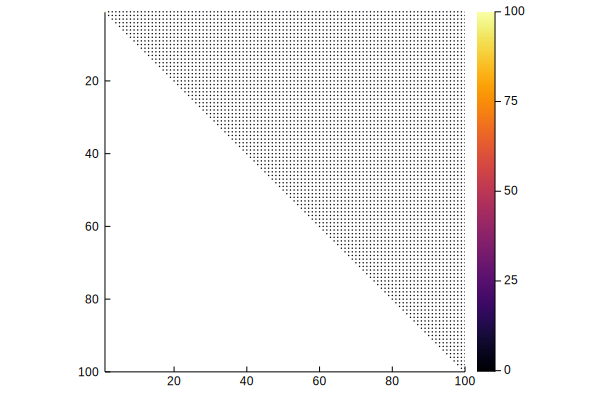

In [40]:
spy(sparse(A))

A matriz $A$ acima é o mais densa possível (para uma matriz triangular superior).
No entanto, uma simples mudança de linhas resolveria o problema.

In [41]:
n = 100
A = diagm(0 => ones(n))
A[:,1] .= 1
A[1,:] .= 1
A[1,1] = n
A[[1;n],:] = A[[n;1],:]
A

100×100 Array{Float64,2}:
   1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
   1.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

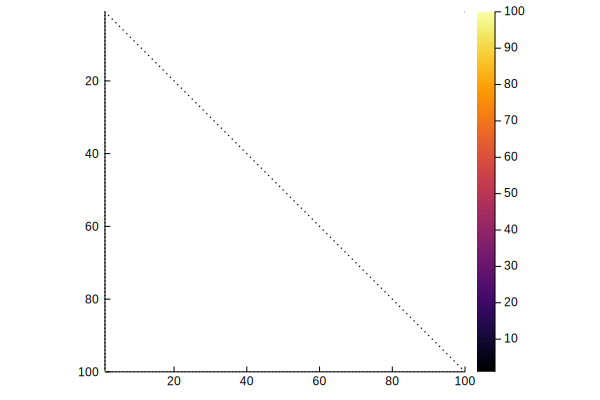

In [42]:
spy(sparse(A))

In [43]:
elim_gauss(A, b)
A

100×100 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0   1.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 ⋮          

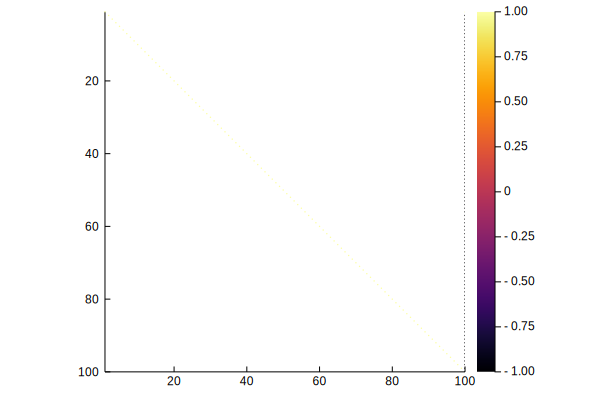

In [44]:
spy(sparse(A))

Esse tipo de pivoteamento melhora a esparsidade, e costuma ser chamado de **pivoteamento para reduzir o preenchimento**.

### Como fazer o pivoteamento

Infelizmente, o pivoteamento para reduzir o preenchimento é complicado. Ele envolve procedimentos mais avançados e com menos garantias de que vai funcionar.
Por outro lado, o pivoteamento para melhorar a estabilidade numérica tem procedimentos mais básicos com verificações imediatas.
Desse modo, iremos focar nesse tipo de pivoteamento.

O pivoteamento para melhor a estabilidade numérica é feita escolhendo a linha a partir do **maior elemento em módulo da coluna atual** do método. Esse elemento, divo **pivô** é escolhido para ficar na diagonal da matriz, de modo que todos os $m_{ij}$ calculados satisfazem $|m_{ij}| \leq 1$. O processo está descrito abaixo.

In [53]:
using Random
Random.seed!(0)
A = rand(4, 4) - rand(4, 4)
b = A * ones(4)
C = [A b]

4×5 Array{Float64,2}:
  0.24776    -0.190424  0.318687  -0.345261   0.030763
  0.0420778   0.141109  0.705232   0.774302   1.66272 
 -0.803234   -0.310827  0.518965  -0.671082  -1.26618 
 -0.590361   -0.699333  0.382653  -0.259264  -1.16631 

In [54]:
# Coluna 1
i = argmax(abs.(C[:,1]))
C[ [i; 1], :] = C[ [1; i], :] # Lᵢ ↔ L₁

2×5 Array{Float64,2}:
  0.24776   -0.190424  0.318687  -0.345261   0.030763
 -0.803234  -0.310827  0.518965  -0.671082  -1.26618 

In [55]:
C

4×5 Array{Float64,2}:
 -0.803234   -0.310827  0.518965  -0.671082  -1.26618 
  0.0420778   0.141109  0.705232   0.774302   1.66272 
  0.24776    -0.190424  0.318687  -0.345261   0.030763
 -0.590361   -0.699333  0.382653  -0.259264  -1.16631 

In [56]:
m = C[2:4, 1] / C[1,1]         # Não se assustem
C[2:4,2:5] .-= m * C[1,2:5]'   # O código está com truques para ser curto
C[2:4,1] .= 0.0                # Mas o resultado é o mesmo que fazer individualmente
C                              # Lᵢ ← Lᵢ - mᵢ₁L₁, i = 2,3,4

4×5 Array{Float64,2}:
 -0.803234  -0.310827  0.518965    -0.671082  -1.26618 
  0.0        0.124826  0.732418     0.739147   1.59639 
  0.0       -0.286299  0.478764    -0.552258  -0.359794
  0.0       -0.470881  0.00122319   0.233969  -0.235689

In [57]:
i = argmax(abs.(C[2:4,2])) + 1
C[ [i; 2], :] = C[ [2; i], :]

2×5 Array{Float64,2}:
 0.0   0.124826  0.732418    0.739147   1.59639 
 0.0  -0.470881  0.00122319  0.233969  -0.235689

In [58]:
C

4×5 Array{Float64,2}:
 -0.803234  -0.310827  0.518965    -0.671082  -1.26618 
  0.0       -0.470881  0.00122319   0.233969  -0.235689
  0.0       -0.286299  0.478764    -0.552258  -0.359794
  0.0        0.124826  0.732418     0.739147   1.59639 

In [59]:
m = C[3:4, 2] / C[2,2]
C[3:4,3:5] .-= m * C[2,3:5]'
C[3:4,2] .= 0.0
C                              # Lᵢ ← Lᵢ - mᵢ₂L₂, i = 3,4

4×5 Array{Float64,2}:
 -0.803234  -0.310827  0.518965    -0.671082  -1.26618 
  0.0       -0.470881  0.00122319   0.233969  -0.235689
  0.0        0.0       0.47802     -0.694513  -0.216493
  0.0        0.0       0.732742     0.80117    1.53391 

In [60]:
i = argmax(abs.(C[3:4,3])) + 2
C[ [i; 3], :] = C[ [3; i], :]

2×5 Array{Float64,2}:
 0.0  0.0  0.47802   -0.694513  -0.216493
 0.0  0.0  0.732742   0.80117    1.53391 

In [61]:
C

4×5 Array{Float64,2}:
 -0.803234  -0.310827  0.518965    -0.671082  -1.26618 
  0.0       -0.470881  0.00122319   0.233969  -0.235689
  0.0        0.0       0.732742     0.80117    1.53391 
  0.0        0.0       0.47802     -0.694513  -0.216493

In [62]:
m = C[4,3] / C[3,3]
C[4,4:5] .-= m * C[3,4:5]
C[4,3] = 0.0
C

4×5 Array{Float64,2}:
 -0.803234  -0.310827  0.518965    -0.671082  -1.26618 
  0.0       -0.470881  0.00122319   0.233969  -0.235689
  0.0        0.0       0.732742     0.80117    1.53391 
  0.0        0.0       0.0         -1.21717   -1.21717 

In [63]:
U = C[1:4, 1:4]
c = C[1:4, 5]
U \ c

4-element Array{Float64,1}:
 1.0               
 1.0000000000000002
 0.9999999999999998
 1.0               

In [74]:
#=
Entrada: matriz A: n×n e vetor b: n

1. Para j de 1 a n-1
    1. Encontra a linha k = argmax {|aᵢⱼ| : i = j,…,n} onde fica o pivô.
    2. Faça Lₖ ↔ Lⱼ
    3. Faça bₖ ← bⱼ
    4. Para i de j+1 a n
        1. Calcule mᵢⱼ = aᵢⱼ/aⱼⱼ
        2. Faça Lᵢ ← Lᵢ - mᵢⱼLⱼ
        3. Faça bᵢ ← bᵢ - mᵢⱼbⱼ

Saída: A triangular superior e 
       b com modificações correspondentes.
=#

A troca de linhas, como já feito anteriormente, é dada por

In [75]:
A = rand(5,5)
j, k = 2, 5
A[[k;j],:] = A[[j;k],:]

2×5 Array{Float64,2}:
 0.72285   0.484661  0.114269  0.184115  0.586712
 0.801924  0.801119  0.104823  0.873581  0.548342

In [64]:
function elim_gauss_pivot(A::Matrix, b::Vector; diagtol = 1e-12)
    n = length(b)
    for j = 1:n-1
        # Implemente o pivoteamento
        pivo = 0.0
        k = j
        # AQUI
        for i = j:n
            if abs(A[i,j]) > pivo
                pivo = abs(A[i,j])
                k = i
            end
        end
        if k != j
            A[ [j, k], :] = A[ [k, j], :]
            b[ [j, k] ]   = b[ [k, j] ]
        end
        ajj, bj = A[j,j], b[j]
        if abs(ajj) <= diagtol
            error("Diagonal muito próxima de 0")
        end
        for i = j+1:n
            mij = A[i,j] / ajj
            A[i,j] = 0.0
            A[i,j+1:n] -= mij * A[j,j+1:n]
            b[i] -= mij * bj
        end
    end
    return A, b
end

elim_gauss_pivot (generic function with 1 method)

In [65]:
A = rand(4, 4)
b = A * ones(4)
elim_gauss_pivot(A, b)

([0.76707 0.899199 0.114269 0.838075; 0.0 -0.812018 0.693437 -0.0130876; 0.0 0.0 1.29141 -0.255553; 0.0 0.0 0.0 0.0478173], [2.61861, -0.131668, 1.03586, 0.0478173])

In [66]:
A \ b

4-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0

In [67]:
A = [1e-12 100; 1 1e-12]
b = A * ones(2)
elim_gauss_pivot(A, b)

([1.0 1.0e-12; 0.0 100.0], [1.0, 100.0])

In [68]:
A \ b

2-element Array{Float64,1}:
 1.0
 1.0

O processo de pivoteamento tem vantagens teóricas também. Note que o maior elemento do restante da coluna é escolhido. Isso quer dizer que se o pivô for nulo (ou suficientemente próximo), então realmente não existe a possibilidade de escalonar aquela matriz com a diagonal diferente de zero.
Em outras palavras, se $A$ é inversível, então a eliminação Gaussiana com pivoteamento deveria funcionar (na aritmética exata).

**Teorema:** Se $\det(A) \neq 0$, então a eliminação Gaussiana com pivoteamento gera uma matriz $A$ com diagonal não nula.

## Complexidade

Vamos analisar agora a complexidade da eliminação Gaussiana. Vamos recopiar a última versão aqui para referência.

In [81]:
#=
Entrada: matriz A: n×n e vetor b: n

1. Para j de 1 a n-1
    1. Encontra a linha k = argmax {|aᵢⱼ| : i = j,…,n} onde fica o pivô.
    2. Faça Lₖ ↔ Lⱼ
    3. Faça bₖ ↔ bⱼ
    4. Para i de j+1 a n
        1. Calcule mᵢⱼ = aᵢⱼ/aⱼⱼ
        2. Faça Lᵢ ← Lᵢ - mᵢⱼLⱼ
        3. Faça bᵢ ← bᵢ - mᵢⱼbⱼ

Saída: A triangular superior e 
       b com modificações correspondentes.
=#

Primeiro o que é mais direto.

- 1.4.1: 1 divisão
- 1.4.2: Cada $a_{i\ell} \leftarrow a_{i\ell} - m_{i j} a_{j\ell}$ são 2 operações.
    Fazemos isso para $\ell = j+1,\dots,n$, logo são $n - j$ vezes, num total de 2(n-j) operações
- 1.4.3: Mais 2 operações.

Um total de $2(n-j)+3$ operações para cada $i$.

Agora o loop 1.4. Ele é feito para $i = j+1,\dots,n$, logo um total de
$[2(n-j)+3](n-j) = 2(n-j)^2 + 3(n-j)$ operações para cada $j$.

 Os passos 1.1-1.3 não muito se feitos corretamente.

O total $2(n-j)^2 + 3(n-j)$ é feito para cada $j = 1,\dots,n-1$, que dá

\begin{align}
\sum_{j=1}^{n-1}[2(n-j)^2 + 3(n-j)]
& = \sum_{j=1}^{n-1}(2j^2 + 3j) \\
& = 2\frac{(n-1)n(2n-1)}{6} + 3\frac{(n-1)n}{2} \\
& = \frac{2}{3}n^3 + \frac{1}{2}n^2 - \frac{7}{6}n.
\end{align}

Agora, a complexidade da resolução do sistema triangular.

In [82]:
#=
Entrada: A: n×n triangular superior com diagonal não-nula
         b: n
1. Crie o vetor x nulo
2. Para i de n à 1, voltando
    1. s ← xᵢ
    2. Para j de i+1 à n
        1. s ← s - aᵢⱼxⱼ
    3. xᵢ = s/aᵢᵢ

Saída: x: solução de Ax = b
=#

Essa é um pouco mais fácil de se calcular.
A operação 1.2.2 faz $2(n-j)$ operações para cada $j$ num total de $2(n-j) + 1$ por $j$.
Logo, temos

\begin{align}
\sum_{j=1}^n [2(n-j) + 1]
& = \sum_{j=0}^{n-1}[2j + 1] \\
& = 2\sum_{j=0}^{n-1}j + n \\
& = (n-1)n + n = n^2.
\end{align}

Portanto, para resolver do zero um sistema linear $Ax = b$ pela eliminação Gaussiana,
fazemos
$$ \frac{2}{3}n^3 + \frac{3}{2}n^2 - \frac{7}{6}n. $$

O mais importante nesse valor todo é o $n^3$. Isso porque ele será o termo que mais "pesa" nessa conta para $n$ grande. Dizemos que a complexidade é da ordem de $n^3$.

Note que a complexidade de multiplicar uma matriz por um vetor é de ordem $n^2$, que é a mesma ordem de resolver um sistema triangular superior. Resolver o sistema do zero, no entanto, é de ordem $n^3$, que é a mesma ordem de multiplicar duas matrizes $n$ por $n$.

# Decomposição LU

In [74]:
A = [4.0 3 2; 2 5 -1; 1 -2 0]

3×3 Array{Float64,2}:
 4.0   3.0   2.0
 2.0   5.0  -1.0
 1.0  -2.0   0.0

In [75]:
m21 = 2 / 4
# L₂ - m₂₁L₁  equivale a E₂₁ × A
E21 = diagm(0 => ones(3)) # Identidate
E21[2,1] = -m21
E21

3×3 Array{Float64,2}:
  1.0  0.0  0.0
 -0.5  1.0  0.0
  0.0  0.0  1.0

In [76]:
E21 * A

3×3 Array{Float64,2}:
 4.0   3.0   2.0
 0.0   3.5  -2.0
 1.0  -2.0   0.0

In [77]:
m31 = A[3,1] / A[1,1]
E31 = diagm(0 => ones(3)) # Identidate
E31[3,1] = -m31
E31

3×3 Array{Float64,2}:
  1.0   0.0  0.0
  0.0   1.0  0.0
 -0.25  0.0  1.0

In [78]:
E31 * E21 * A

3×3 Array{Float64,2}:
 4.0   3.0    2.0
 0.0   3.5   -2.0
 0.0  -2.75  -0.5

In [79]:
E31 * E21

3×3 Array{Float64,2}:
  1.0   0.0  0.0
 -0.5   1.0  0.0
 -0.25  0.0  1.0

In [80]:
A2 = E31 * E21 * A

3×3 Array{Float64,2}:
 4.0   3.0    2.0
 0.0   3.5   -2.0
 0.0  -2.75  -0.5

In [81]:
m32 = A2[3,2] / A2[2,2]
E32 = diagm(0 => ones(3)) # Identidate
E32[3,2] = -m32
E32

3×3 Array{Float64,2}:
 1.0  0.0       0.0
 0.0  1.0       0.0
 0.0  0.785714  1.0

In [82]:
E32 * A2

3×3 Array{Float64,2}:
 4.0  3.0   2.0    
 0.0  3.5  -2.0    
 0.0  0.0  -2.07143

In [83]:
E32 * E31 * E21 * A

3×3 Array{Float64,2}:
 4.0          3.0   2.0    
 0.0          3.5  -2.0    
 2.22045e-16  0.0  -2.07143

In [84]:
E32 * E31 * E21

3×3 Array{Float64,2}:
  1.0       0.0       0.0
 -0.5       1.0       0.0
 -0.642857  0.785714  1.0

In [85]:
inv(E32 * E31 * E21)

3×3 Array{Float64,2}:
 1.0    0.0       0.0
 0.5    1.0       0.0
 0.25  -0.785714  1.0

In [95]:
inv(E21)

3×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.5  1.0  0.0
 0.0  0.0  1.0

In [96]:
inv(E31)

3×3 Array{Float64,2}:
 1.0   0.0  0.0
 0.0   1.0  0.0
 0.25  0.0  1.0

In [97]:
inv(E32)

3×3 Array{Float64,2}:
 1.0   0.0       0.0
 0.0   1.0       0.0
 0.0  -0.785714  1.0

In [98]:
inv(E21) * inv(E31) * inv(E32)

3×3 Array{Float64,2}:
 1.0    0.0       0.0
 0.5    1.0       0.0
 0.25  -0.785714  1.0

In [86]:
L = diagm(0 => ones(3))
L[2,1] = m21
L[3,1] = m31
L[3,2] = m32
L

3×3 Array{Float64,2}:
 1.0    0.0       0.0
 0.5    1.0       0.0
 0.25  -0.785714  1.0

In [87]:
U = E32 * E31 * E21 * A

3×3 Array{Float64,2}:
 4.0          3.0   2.0    
 0.0          3.5  -2.0    
 2.22045e-16  0.0  -2.07143

In [88]:
L * U

3×3 Array{Float64,2}:
 4.0   3.0   2.0
 2.0   5.0  -1.0
 1.0  -2.0   0.0

In [102]:
L * U - A

3×3 Array{Float64,2}:
 0.0          0.0  0.0
 0.0          0.0  0.0
 2.22045e-16  0.0  0.0

In [103]:
# A = L * U
# Ax = b ⇒ LUx = b
# x = U⁻¹L⁻¹b
b = A * ones(3)
(U \ (L \ b))

3-element Array{Float64,1}:
 0.9999999999999998
 1.0000000000000002
 1.0000000000000002

In [89]:
function declu(A::Matrix; diagtol = 1e-12)
    n = size(A, 1)
    for j = 1:n-1
        ajj = A[j,j]
        if abs(ajj) <= diagtol
            error("Diagonal muito próxima de 0")
        end
        Lj = A[j,j+1:n]
        for i = j+1:n
            mij = A[i,j] / ajj
            A[i,j+1:n] = A[i,j+1:n] - mij * Lj
            A[i,j] = mij
        end
    end
    # Crie L e U
    # Veja o help do tril e do triu
    return tril(A,-1) + I, triu(A)
end

declu (generic function with 1 method)

In [90]:
A = [3.0 1 2; -1 2 1; 1 1 4]
L, U = declu(copy(A))

([1.0 0.0 0.0; -0.333333 1.0 0.0; 0.333333 0.285714 1.0], [3.0 1.0 2.0; 0.0 2.33333 1.66667; 0.0 0.0 2.85714])

In [91]:
L

3×3 Array{Float64,2}:
  1.0       0.0       0.0
 -0.333333  1.0       0.0
  0.333333  0.285714  1.0

In [92]:
U

3×3 Array{Float64,2}:
 3.0  1.0      2.0    
 0.0  2.33333  1.66667
 0.0  0.0      2.85714

In [93]:
L * U - A

3×3 Array{Float64,2}:
 0.0  0.0           0.0        
 0.0  0.0          -1.11022e-16
 0.0  2.22045e-16   0.0        

In [127]:
A = rand(3, 3)
L, U = declu(copy(A))
norm(L * U - A)

2.7194799110210365e-16

In [128]:
A = rand(3, 3)

3×3 Array{Float64,2}:
 0.105433  0.148241  0.520891
 0.961397  0.170873  0.702288
 0.349087  0.30807   0.82818 

In [132]:
tril(A, -1) + I

3×3 Array{Float64,2}:
 1.0       0.0      0.0
 0.961397  1.0      0.0
 0.349087  0.30807  1.0

In [133]:
triu(A)

3×3 Array{Float64,2}:
 0.105433  0.148241  0.520891
 0.0       0.170873  0.702288
 0.0       0.0       0.82818 

No ponto atual, conseguimos resolver um sistema linear, sobre algumas
condições. Temos um problema, no entanto, e se quisermos resolver
mais de um sistema linear, e não tivermos todas os vetores do lado direito de imediato?

Isso acontece com frequência em muitas aplicações. Em particular, em otimização linear e não-linear com restrições lineares, essa situação é bastante comum. Também para o cálculo de autovalores e autovetores de uma matriz, existe um método que faz isso. De maneira geral, é como se a matriz $A$ fosse uma parte fixa de um modelo e o vetor $b$ fosse uma parte móvel.

Se precisamos resolver muitos sistemas com a mesma matriz $A$,
e começarmos do zero todos eles, teremos uma complexidade de ordem $n^3$ **para cada iteração desse método**.
No entanto, se tivermos os valores de $m_{ij}$, podemos fazer as operações necessárias
apenas no vetor do lado direito.

Note que temos $\dfrac{(n-1)n}{2}$ elementos $m_{ij}$ para guardar.
Não por acaso, eles equivalem a cada um dos zeros da matriz $A$
final.
Sendo assim, podemos **utilizar a própria matriz $A$ para guardar $m_{ij}$.**

Note também, que precisamos guardar as permutações que foram feitas, pois as linhas do vetor do lado direito também precisam ser trocadas.
Por enquanto, para facilitar o entendimento, vamos considerar a eliminação sem pivoteamento novamente.

Também precisamos criar uma função para aplicar os valores de $m_{ij}$ à um vetor $b$.
No entanto, veja que podemos ir direto ao objetivo e aproveitar e resolver o sistema logo.
Note que a aplicação dos $m_{ij}$ modifica o vetor $b$, e além disso criamos um novo vetor $x$. Isso quer dizer que estamos
- perdendo o $b$ original; e
- gastando mais memória com $x$.

Podemos resolver um desses problemas. As opções são
1. Copiar o $b$ para o $x$, aplicar $m_{ij}$ no $x$ e resolver o sistema modificando o $x$ para ser a solução no fim; ou
2. Aplicar $m_{ij}$ em $b$, e resolver o sistema modificando o $b$ para ser a solução no fim.

A opção 1 resolve o problema de perder $b$. Ao fim teremos $b$ e um novo $x$ que será a solução de $Ax = b$.

A opção 2 resolve o problema de gastar memória. Perderemos $b$, mas teremos a solução sem gasto de memória adicional.

A segunda opção é melhor pois se quisermos manter $b$, podemos copiar $b$ antes de chamar a função.

In [112]:
#=
Entrada: A: n×n onde a parte triangular superior é corresponde ao resultado
    da eliminação Gaussiana, e a parte triangular inferior sem a diagonal
    corresponde aos valores mᵢⱼ
         b: n   que será modificado para guardar a solução do sistema.

1. Para i de 1 a n
    1. Para j de 1 a i-1
        1. Faça bᵢ ← bᵢ - aᵢⱼbⱼ
2. Para 1 de n à 1, voltando
    1. s ← bᵢ
    2. Para j de i+1 à n
        1. s ← s - aᵢⱼbⱼ
    3. bᵢ = s/aᵢᵢ
=#

In [142]:
function resolvelu(L, U, b)
    n = length(b)
    # Implemente
    # Ly = b
    y = zeros(n)
    for i = 1:n
        s = 0.0
        for j = 1:i-1
            s += L[i,j] * y[j]
        end
        y[i] = b[i] - s
    end
    
    # Ux = y
    x = zeros(n)
    for i = n:-1:1
        s = 0.0
        for j = i+1:n
            s += U[i,j] * x[j]
        end
        x[i] = (y[i] - s) / U[i,i]
    end
    return x
end

resolvelu (generic function with 1 method)

In [143]:
A = [3.0 1 2; -1 2 1; 1 1 4]
b = A * ones(3)

L, U = declu(copy(A))
x = resolvelu(L, U, b)

3-element Array{Float64,1}:
 1.0               
 1.0000000000000002
 0.9999999999999999

Vamos analisar a primeira parte de `resolvelu` com mais detalhes, pensando num caso 3x3.

In [115]:
#= x é o valor de saída
Começo x₁ = b₁, x₂ = b₂, x₃ = b₃
j = 1
  i = 2
    x₂ ← x₂ - m₂₁x₁
  i = 3
    x₃ ← x₃ - m₃₁x₁
j = 2
  i = 3
    x₃ ← x₃ - m₃₂x₂
=#

No final desse processo temos as seguintes relações

\begin{align}\left\{\begin{array}{rcl}
x_1 & = & b_1 \\
x_2 & = & b_2 - m_{21} x_1 \\
x_3 & = & b_3 - m_{31} x_1 - m_{32} x_2.
\end{array}\right.
\end{align}

Isso quer dizer que

\begin{align}\left\{
\begin{array}{rcrcrcl}
      x_1 & &           & &     & = & b_1 \\
m_{21}x_1 &+&       x_2 & &     & = & b_2 \\
m_{31}x_1 &+& m_{32}x_2 &+& x_3 & = & b_3
\end{array}\right.
\end{align}

Que corresponde ao sistema linear $Lx = b$, onde $L$ é a matriz

$$\left[\begin{array}{ccc}
1 & 0 & 0 \\
m_{21} & 1 & 0 \\
m_{31} & m_{32} & 1
\end{array}\right].$$

Isso quer dizer que fazer eliminação Gaussiana em $\left[\begin{array}{cc}A & b\end{array}\right]$ é equivalente a fazer eliminação Gaussiana apenas em $A$, guardar $m_{ij}$ em $L$ e calcular $L^{-1}b$. Note que $\det(L) = 1$ e por isso sempre existe a inversa.

Chamando a matriz resultante da eliminação Gaussiana em $A$ de $U$, podemos dizer que começamos com o sistema
$$ Ax = b, $$
e acabamos com o sistema
$$ Ux = L^{-1}b. $$

Mas então podemos fazer
$$ LUx = b. $$

Será que $A = LU$? A resposta é sim, pois os valores de $x$ e $b$ não são usados para se calcular nem $L$ nem $U$. Portanto, podemos mudar $x$ e obter um $b$ correspondente, e os dois sistemas continuarão válidos. Outra maneira de ver isso é subtrair os dois sistemas, obtendo $(A - LU)x = 0$, e variar $x$ para cada coluna da identidade.

Concluindo, o processo de eliminação Gaussiana nos dá uma maneira de representar $A$ que depende de duas matrizes mais simples. Chamamos essa maneira de **fatoração LU**.

Existem várias fatorações matriciais. Algumas são bem conhecidas, e algumas são bem específicas. A fatoração LU é a mais famosa, pois não depende de nenhuma propriedade especial da matriz para existe, com exceção do Teorema que passamos.

Dado a fatoração $LU$ da matriz $A$, não iremos mais pensar em resolver $Ax = b$ como a aplicação da eliminação Gaussiana, e sim como a resolução de sistemas triangulares.

Dado $Ax = b$, e $A = LU$, temos
$$ LUx = b. $$
Para resolver esse sistema, fazemos $Ux = y$, obtendo
$$ \left\{\begin{array}{rcl}
Ly & = & b \\
Ux & = & y.
\end{array}\right. $$

Dessa maneira, fica óbvio que resolvemos dois sistemas triangulares.

Para resolver o sistema triangular $Ly = b$, veja que
$$\left\{\begin{array}{rcl}
y_1 & = & b_1 \\
y_2 & = & b_2 - m_{21}y_1 \\
y_3 & = & b_3 - m_{31}y_1 - m_{32}y_2 \\
\vdots & & \vdots \\
y_n & = & b_n - \sum_{j=1}^{n-1} m_{nj} y_j.
\end{array}\right.$$

Em outras palavras,
$$ y_i = b_i - \sum_{j = 1}^{i - 1}m_{ij} y_j, \qquad i = 1,\dots,n. $$

Veja que se calculamos na ordem natural $1,\dots,n$, teremos os valores necessários para definir todos os $y_i$.

Abaixo vemos o algoritmo para resolver esse sistema, e vamos substituir $b$ de entrada pelo valor de $y$ de saída.

In [121]:
#=
Entrada: L: nxn triangular inferior com diagonal de 1
         b: n
1. Para i de 1 à n-1
    1. Para j de 1 à i-1
        1. bᵢ ← bᵢ - mᵢⱼ bⱼ
=#

Comparando com o algoritmo que faz a eliminação Gaussiana em $b$, vemos uma leva diferença

In [122]:
#= Algoritmo que faz elim. Gauss. em b
1. Para j de 1 a n-1
    1. Para i de j+1 a n
        1. Faça bᵢ ← bᵢ - aᵢⱼbⱼ
=#

A ordem desse algoritmo está diferente, e os limites para os loops de $i$ e $j$ também. No entanto, a operação que é calculada é a mesma (lembre-se que $a_{ij} = m_{ij}$).

### Fatoração LU com pivoteamento

Como vimos anteriormente, a qualidade da solução do sistema pela eliminação Gaussiana, muda drasticamente quanto utilizamos pivotamento. Na fatoração LU, isso também é verdade.

Agora que guardamos a matriz $L$, o pivoteamento também irá afetá-la. Além disso, queremos calcular a fatoração sem a necessidade de um vetor do lado direito, então precisamos guardar o pivoteamento feito para fazê-lo no vetor $b$ também.

In [144]:
A = [ 1  3  0  1;
      2  1  1  1;
     -3 -1 -1 -3;
     -1 -1  0 -1.0]
B = copy(A)

4×4 Array{Float64,2}:
  1.0   3.0   0.0   1.0
  2.0   1.0   1.0   1.0
 -3.0  -1.0  -1.0  -3.0
 -1.0  -1.0   0.0  -1.0

In [145]:
p = [1;2;3;4]

4-element Array{Int64,1}:
 1
 2
 3
 4

In [146]:
# pivô: a₃₁, L₁ ↔ L₃
p[3], p[1] = p[1], p[3]
A[3,:], A[1,:] = A[1,:], A[3,:]
A

4×4 Array{Float64,2}:
 -3.0  -1.0  -1.0  -3.0
  2.0   1.0   1.0   1.0
  1.0   3.0   0.0   1.0
 -1.0  -1.0   0.0  -1.0

In [147]:
m = A[2:4,1] / A[1,1]
A[2:4,1] = m
A[2:4,2:4] -= m * A[1,2:4]'
A

4×4 Array{Float64,2}:
 -3.0       -1.0       -1.0       -3.0
 -0.666667   0.333333   0.333333  -1.0
 -0.333333   2.66667   -0.333333   0.0
  0.333333  -0.666667   0.333333   0.0

In [149]:
p'

1×4 Adjoint{Int64,Array{Int64,1}}:
 3  2  1  4

In [150]:
# pivô: a₃₂, L₂ ↔ L₃
p[3], p[2] = p[2], p[3]
A[3,:], A[2,:] = A[2,:], A[3,:]
A

4×4 Array{Float64,2}:
 -3.0       -1.0       -1.0       -3.0
 -0.333333   2.66667   -0.333333   0.0
 -0.666667   0.333333   0.333333  -1.0
  0.333333  -0.666667   0.333333   0.0

In [151]:
m = A[3:4,2] / A[2,2]
A[3:4,2] = m
A[3:4,3:4] -= m * A[2,3:4]'
A

4×4 Array{Float64,2}:
 -3.0       -1.0      -1.0       -3.0
 -0.333333   2.66667  -0.333333   0.0
 -0.666667   0.125     0.375     -1.0
  0.333333  -0.25      0.25       0.0

In [129]:
# pivô: a₃₃, não há troca

In [152]:
m = A[4,3] / A[3,3]
A[4,3] = m
A[4,4] -= m * A[3,4]
A

4×4 Array{Float64,2}:
 -3.0       -1.0      -1.0       -3.0     
 -0.333333   2.66667  -0.333333   0.0     
 -0.666667   0.125     0.375     -1.0     
  0.333333  -0.25      0.666667   0.666667

In [153]:
L = tril(A, -1) + I

4×4 Array{Float64,2}:
  1.0        0.0    0.0       0.0
 -0.333333   1.0    0.0       0.0
 -0.666667   0.125  1.0       0.0
  0.333333  -0.25   0.666667  1.0

In [154]:
U = triu(A)

4×4 Array{Float64,2}:
 -3.0  -1.0      -1.0       -3.0     
  0.0   2.66667  -0.333333   0.0     
  0.0   0.0       0.375     -1.0     
  0.0   0.0       0.0        0.666667

In [157]:
p'

1×4 Adjoint{Int64,Array{Int64,1}}:
 3  1  2  4

In [155]:
P = Matrix(1.0I, 4, 4)[p,:]

4×4 Array{Float64,2}:
 0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0

O vetor $p$ corresponde à uma **matriz de permutação** $P$. Uma matriz de permutação é uma matriz obtida a partir de permutações de linhas e permutações de colunas na matriz identidade.
- Se a matriz $P$ é obtida a partir de uma sequência de permutações nas **linhas** da matriz identidade, então a matriz $PA$ é a matriz resultante das mesmas permutações nas linhas de $A$. Nesse caso, dizemos que $P$ é uma **matriz de permutação de linhas**.
- Análogo para colunas, e para a matriz $AP$.

O vetor $p$ tem os índices dessas linhas. Inicialmente, $p$ é um vetor com $p_i = i$, que significa que $P$ é a identidade. Cada modificação no passo XXX modifica elementos de $p$ e as linhas correspondentes de $P$.

Uma matriz de permutação de linhas também é uma matriz de permutação de colunas, mas com outras permutações (a priori indetermidanas).

**Exercício:** Mostre que se $P$ é uma matriz de permutação de linhas, então $P^T$ é uma matriz de permutação de colunas.

Uma parte não trivial do processo da fatoração LU com pivoteamento é descobrir a relação entre $A$, $L$, $U$ e $P$. Como não dispomos do tempo, vamos simplesmente enunciar essa relação.

**Teo.:** Se $A$ é não-singular, o algoritmo de fatoração LU com pivoteamento parcial da matriz $A$ retorna matrizes $L$, $U$ e $P$ tais que
$$ PA = LU. $$

In [158]:
P * B - L * U

4×4 Array{Float64,2}:
 0.0  0.0   0.0          0.0
 0.0  0.0   0.0          0.0
 0.0  0.0   0.0          0.0
 0.0  0.0  -9.25186e-18  0.0

In [159]:
B[p,:] - L * U

4×4 Array{Float64,2}:
 0.0  0.0   0.0          0.0
 0.0  0.0   0.0          0.0
 0.0  0.0   0.0          0.0
 0.0  0.0  -9.25186e-18  0.0

\begin{align}
Ax & = b \\
PAx & = Pb \\
LUx & = Pb.
\end{align}

Daí, temos
$$\left\{
\begin{array}{rcl}
c & = & Pb \\
Ly & = & c \\
Ux & = & y
\end{array}
\right.$$

In [160]:
b = B * ones(4)

4-element Array{Float64,1}:
  5.0
  5.0
 -8.0
 -3.0

In [161]:
c = b[p]
y = L \ c
x = U \ y

4-element Array{Float64,1}:
 1.0               
 1.0               
 1.0               
 0.9999999999999999

A implementação do algoritmo está abaixo.

In [163]:
function declupivot(A::Matrix; diagtol = 1e-12)
    n = size(A, 2)
    p = collect(1:n)
    for j = 1:n-1
        # Quem é o pivô
        pivo, k = abs(A[j,j]), j
        for i = j+1:n
            if abs(A[i,j]) > pivo
                pivo, k = abs(A[i,j]), i
            end
        end
        if pivo <= diagtol
            error("Matriz singular ou muito próxima de ser singular")
        end
        
        if k != j
            p[k], p[j] = p[j], p[k]
            A[[k;j],:] = A[[j;k],:]
        end
        ajj = A[j,j]
        for i = j+1:n
            mij = A[i,j] / ajj
            A[i,j] = mij
            A[i,j+1:n] -= mij * A[j,j+1:n]
        end
    end
    return p
end

declupivot (generic function with 1 method)

In [164]:
A = [ 1  3  0  1;
      2  1  1  1;
     -3 -1 -1 -3;
     -1 -1  0 -1.0]
p = declupivot(A)
A

4×4 Array{Float64,2}:
 -3.0       -1.0      -1.0       -3.0     
 -0.333333   2.66667  -0.333333   0.0     
 -0.666667   0.125     0.375     -1.0     
  0.333333  -0.25      0.666667   0.666667

## Exercícios

Exercícios do capítulo 3 do livro Cálculo Numérico de Ruggiero e Lopes, com exceção daqueles que não competem ao assunto.

1. Sabendo que $P^TP = I$, mostre como resolver o sistema linear $A^T\lambda = c$ usando a fatoração LU.
1. Quando a matriz $A$ é sobrescrita pela fatoração $LU$, nada é perdido. Faça um algoritmo que descreve como calcular o produto $Ax$ pra um vetor $x$ quando a matriz $A$ foi sobrescrita. Compare o número de operações nesse produto com o número de operações no produto com $A$ na forma original.
1. Escreva um algoritmo de fatoração LU e resolução de sistema para matrizes tridiagonais, usando como entrada apenas 3 vetores, correspondentes às diagonais existentes da matriz.
1. Uma matriz singular pode não ter fatoração $LU$ da maneira que vimos. No entanto, é possível estender a fatoração para continuar o processo, mesmo se encontrarmos um zero na diagonal. Estude como fazer isso. Teste com matrizes cuja primeira coluna é nula. Compare com o `lu` já implementado no Julia.
1. Uma matriz não quadrada também pode ter fatoração LU, estendo o conceito da questão anterior. Estude como fazer isso.
1. *Uma matriz de banda é uma extensão da matriz tridiagonal. Uma matriz com bandas $a \geq 0$ e $b \geq 0$ é uma matriz $A$ com $a$ diagonais abaixo da diagonal e $b$ diagonais acima da diagonal. Se $a = b = 1$, a matriz é tridiagonal. Para representar uma matriz de banda $A \in \mathbb{R}^{n\times n}$, costuma-se usar uma matriz $D \in \mathbb{R}^{1+a+b}\times n$, onde cada linha corresponde à uma diagonal de $A$.
Escreva um algoritmo que faz a fatoração LU dessa matriz de banda e resolve um sistema linear usando essa fatoração. Descreva a posição dos elementos de $A$ na matriz $D$.
1. *O pivoteamento da fatoração LU é feito sempre que algum elemento da coluna abaixo da diagonal é maior que o elemento da diagonal. Porém, trocar linhas também é custoso, então podemos fazer um compromisso entre melhorar a estabilidade e diminuir a troca de linhas usando a condição a seguir:
$$ \mbox{se existe $i > j$ tal que } \qquad
|a_{ij}| > \alpha |a_{jj}|,
\qquad \mbox{ então faça a troca}. $$
A constante $\alpha \geq 1$ define o nível do compromisso. Se $\alpha = 1$ temos o pivotamento visto acima.
Se $\alpha \rightarrow \infty$, então a troca só é feita se $a_{jj} = 0$.
Faça um algoritmo que implementa essa mudança, com $\alpha$ sendo um parâmetro opcional de entrada.
1. *O pivoteamento de linhas para diminuição da esparsidade pode ser feito buscando a linha que tem a maior quantidade de zeros. Deve-se apenas tomar cuidado para que não se piore demais a estabilidade do método.
Modificando a condição acima, escreva e implemente o algoritmo que faz um pivoteamento buscando a esparsidade.